<a href="https://colab.research.google.com/github/ascii-monk123/Diabetic-Retinopathy-Ensemble/blob/main/Diabetic_Retinopathy_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,Activation
from keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import os
import seaborn as sns


<h2>Loading the dataset</h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2> Developing data generators </h2>

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,
                                  zoom_range = 0.2, horizontal_flip = True)

train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/archive-2/train',target_size=(224, 224),
                                              class_mode='categorical', batch_size = 32, shuffle = True)

Found 2076 images belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/archive-2/valid',target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical', shuffle = True)

Found 531 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/archive-2/test', target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical', shuffle = True)

Found 231 images belonging to 2 classes.


<h2>VGG19</H2>

In [ ]:
model = keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))


In [ ]:
for layers in model.layers:
    layers.trainable = False


In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg19 = Sequential([model, Flatten(), Dropout(0.2), Dense(256, activation = 'relu'), Dropout(0.2), Dense(2, activation = 'softmax')])


In [ ]:
#callbacks
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 4,
                             verbose = 1, mode = 'max', min_lr = 1e-5)

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1,
                              mode = 'max', restore_best_weights = True, start_from_epoch = 11)

checkpoint_path = '/custom_cnn.tf'

checkpoint = ModelCheckpoint(filepath = checkpoint_path, verbose = 1,
                            monitor = 'val_accuracy', save_best_only = True,
                            mode = 'max')


In [ ]:
vgg19.compile(
    optimizer = Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = vgg19.fit(
    train_set, epochs = 20, validation_data = val_set, callbacks = [reduce_lr, early_stopping, checkpoint]
)

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 1.0495 - accuracy: 0.8276
Epoch 1: val_loss improved from inf to 0.20650, saving model to /custom_cnn.tf
65/65 [==============================] - 33s 439ms/step - loss: 1.0495 - accuracy: 0.8276 - val_loss: 0.2065 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9109
Epoch 2: val_loss did not improve from 0.20650
65/65 [==============================] - 25s 391ms/step - loss: 0.2361 - accuracy: 0.9109 - val_loss: 0.2452 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9138
Epoch 3: val_loss improved from 0.20650 to 0.17563, saving model to /custom_cnn.tf
65/65 [==============================] - 28s 428ms/step - loss: 0.2346 - accuracy: 0.9138 - val_loss: 0.1756 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.2168

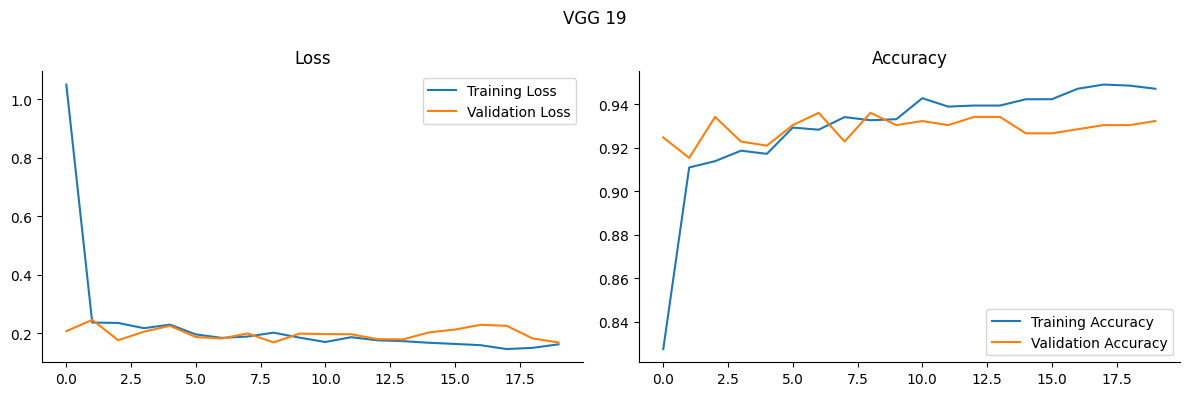

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"],
             ax = axes[0], label = "Training Loss")

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"],
             ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["accuracy"],
             ax = axes[1], label = "Training Accuracy")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["val_accuracy"],
             ax = axes[1], label = "Validation Accuracy")

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
fig.suptitle("VGG 19")

plt.tight_layout()

sns.despine()
plt.savefig('vgg19.eps', format = 'eps', dpi = 1200)
plt.savefig('vgg19.png', format = 'png', dpi = 1200)

In [ ]:
!zip -r /content/file.zip /custom_cnn.tf

  adding: custom_cnn.tf/ (stored 0%)
  adding: custom_cnn.tf/keras_metadata.pb (deflated 96%)
  adding: custom_cnn.tf/assets/ (stored 0%)
  adding: custom_cnn.tf/variables/ (stored 0%)
  adding: custom_cnn.tf/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: custom_cnn.tf/variables/variables.index (deflated 67%)
  adding: custom_cnn.tf/fingerprint.pb (stored 0%)
  adding: custom_cnn.tf/saved_model.pb (deflated 90%)


In [ ]:
m2 = tf.keras.models.load_model(checkpoint_path)

In [ ]:
m2.evaluate(test_set)

8/8 [==============================] - 1s 113ms/step - loss: 0.1360 - accuracy: 0.9481


[0.13600754737854004, 0.948051929473877]

<h2>Resnet</h2>

In [ ]:
model = keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
for layers in model.layers:
    layers.trainable = False


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg16 = Sequential([model, Flatten(), Dropout(0.2), Dense(256, activation = 'relu'), Dropout(0.2), Dense(2, activation = 'softmax')])

In [ ]:
vgg16.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_12 (Dropout)        (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 64

In [ ]:
vgg16.compile(
    optimizer = Adam(lr = 0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = vgg16.fit(
    train_set, epochs = 20, validation_data = val_set, callbacks = [reduce_lr, early_stopping, checkpoint]
)

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 0.8428 - accuracy: 0.8348
Epoch 1: val_accuracy improved from 0.54614 to 0.92655, saving model to /custom_cnn.tf
65/65 [==============================] - 28s 420ms/step - loss: 0.8428 - accuracy: 0.8348 - val_loss: 0.1932 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9205
Epoch 2: val_accuracy improved from 0.92655 to 0.93032, saving model to /custom_cnn.tf
65/65 [==============================] - 29s 441ms/step - loss: 0.2392 - accuracy: 0.9205 - val_loss: 0.1787 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9253
Epoch 3: val_accuracy improved from 0.93032 to 0.93220, saving model to /custom_cnn.tf
65/65 [==============================] - 28s 424ms/step - loss: 0.2196 - accuracy: 0.9253 - val_loss: 0.1787 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 4/20
65/65 [====

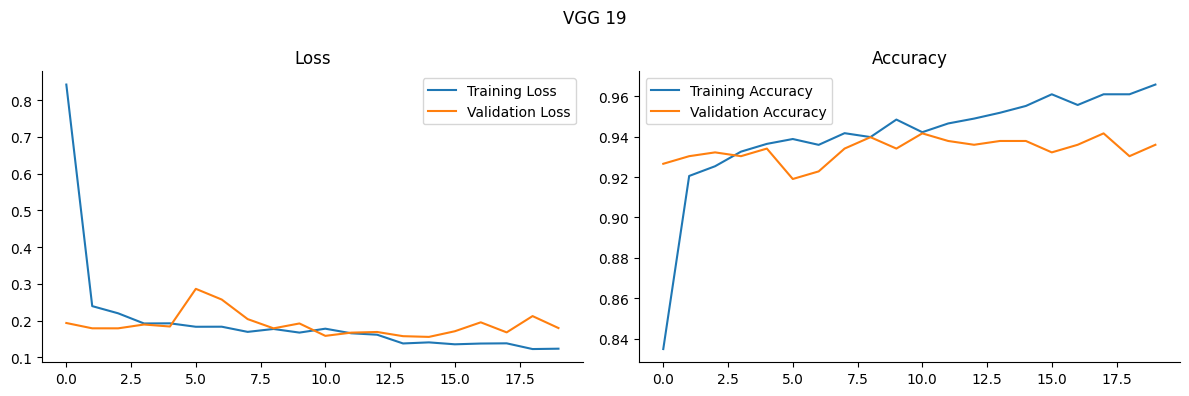

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"],
             ax = axes[0], label = "Training Loss")

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"],
             ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["accuracy"],
             ax = axes[1], label = "Training Accuracy")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["val_accuracy"],
             ax = axes[1], label = "Validation Accuracy")

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
fig.suptitle("VGG 19")

plt.tight_layout()

sns.despine()
plt.savefig('vgg16.eps', format = 'eps', dpi = 1200)
plt.savefig('vgg16.png', format = 'png', dpi = 1200)

In [ ]:
m2 = tf.keras.models.load_model(checkpoint_path)

In [ ]:
m2.evaluate(test_set)

8/8 [==============================] - 1s 69ms/step - loss: 0.1363 - accuracy: 0.9610


[0.1362587809562683, 0.9610389471054077]

In [ ]:
!zip -r /content/vgg16.zip /custom_cnn.tf

  adding: custom_cnn.tf/ (stored 0%)
  adding: custom_cnn.tf/keras_metadata.pb (deflated 96%)
  adding: custom_cnn.tf/assets/ (stored 0%)
  adding: custom_cnn.tf/variables/ (stored 0%)
  adding: custom_cnn.tf/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: custom_cnn.tf/variables/variables.index (deflated 65%)
  adding: custom_cnn.tf/fingerprint.pb (stored 0%)
  adding: custom_cnn.tf/saved_model.pb (deflated 89%)


<h2>InceptionV3</h2>

In [ ]:
model = keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
for layers in model.layers:
    layers.trainable = False


87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
inception_v3 = Sequential([model, Flatten(), Dropout(0.2), Dense(256, activation = 'relu'), Dropout(0.2), Dense(2, activation = 'softmax')])

In [ ]:
inception_v3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_14 (Dropout)        (None, 51200)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
Total params: 34910754 (133.17 MB)
Trainable params: 1

In [ ]:
inception_v3.compile(
    optimizer = Adam(lr = 0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = inception_v3.fit(
    train_set, epochs = 20, validation_data = val_set, callbacks = [reduce_lr, early_stopping, checkpoint]
)

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 5.4780 - accuracy: 0.8439
Epoch 1: val_accuracy did not improve from 0.94162
65/65 [==============================] - 32s 414ms/step - loss: 5.4780 - accuracy: 0.8439 - val_loss: 0.6132 - val_accuracy: 0.9284 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.9061
Epoch 2: val_accuracy did not improve from 0.94162
65/65 [==============================] - 26s 397ms/step - loss: 0.5941 - accuracy: 0.9061 - val_loss: 0.2193 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9403
Epoch 3: val_accuracy did not improve from 0.94162
65/65 [==============================] - 26s 396ms/step - loss: 0.2036 - accuracy: 0.9403 - val_loss: 0.1886 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9513
Epoch 4: val_accuracy improved from 

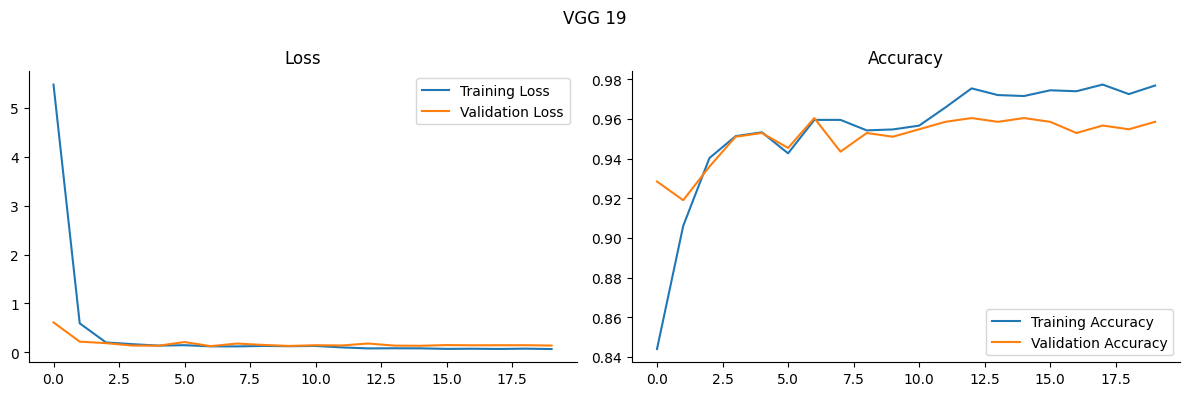

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"],
             ax = axes[0], label = "Training Loss")

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"],
             ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["accuracy"],
             ax = axes[1], label = "Training Accuracy")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["val_accuracy"],
             ax = axes[1], label = "Validation Accuracy")

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
fig.suptitle("VGG 19")

plt.tight_layout()

sns.despine()
plt.savefig('inception_v3.eps', format = 'eps', dpi = 1200)
plt.savefig('inception_v3.png', format = 'png', dpi = 1200)

In [ ]:
!zip -r /content/inception_v3.zip /custom_cnn.tf

  adding: custom_cnn.tf/ (stored 0%)
  adding: custom_cnn.tf/keras_metadata.pb (deflated 96%)
  adding: custom_cnn.tf/assets/ (stored 0%)
  adding: custom_cnn.tf/variables/ (stored 0%)
  adding: custom_cnn.tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: custom_cnn.tf/variables/variables.index (deflated 77%)
  adding: custom_cnn.tf/fingerprint.pb (stored 0%)
  adding: custom_cnn.tf/saved_model.pb (deflated 92%)


In [ ]:
!unzip inception_v3.zip

Archive:  inception_v3.zip
   creating: custom_cnn.tf/
  inflating: custom_cnn.tf/keras_metadata.pb  
   creating: custom_cnn.tf/assets/
   creating: custom_cnn.tf/variables/
  inflating: custom_cnn.tf/variables/variables.data-00000-of-00001  
  inflating: custom_cnn.tf/variables/variables.index  
 extracting: custom_cnn.tf/fingerprint.pb  
  inflating: custom_cnn.tf/saved_model.pb  


In [ ]:
!unzip /inception_v3.zip

Archive:  /inception_v3.zip
   creating: custom_cnn.tf/
  inflating: custom_cnn.tf/keras_metadata.pb  
   creating: custom_cnn.tf/assets/
   creating: custom_cnn.tf/variables/
  inflating: custom_cnn.tf/variables/variables.data-00000-of-00001  
  inflating: custom_cnn.tf/variables/variables.index  
 extracting: custom_cnn.tf/fingerprint.pb  
  inflating: custom_cnn.tf/saved_model.pb  


In [ ]:
m2 = tf.keras.models.load_model('/content/custom_cnn.tf')

In [ ]:
m2.evaluate(test_set)

8/8 [==============================] - 2s 126ms/step - loss: 0.1160 - accuracy: 0.9610


[0.1160331666469574, 0.9610389471054077]

<h2>MobileNetv2</h2>


In [ ]:
model = keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
for layers in model.layers:
    layers.trainable = False

mobilenetv2 = Sequential([model, Flatten(), Dropout(0.2), Dense(256, activation = 'relu'), Dropout(0.2), Dense(2, activation = 'softmax')])
mobilenetv2.summary()
mobilenetv2.compile(
    optimizer = Adam(lr = 0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
history = mobilenetv2.fit(
    train_set, epochs = 20, validation_data = val_set, callbacks = [reduce_lr, early_stopping, checkpoint]
)

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_8 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_16 (Dropout)        (None, 62720)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               16056576  
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 2)                 51

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 3.1040 - accuracy: 0.8801
Epoch 1: val_accuracy did not improve from 0.96045
65/65 [==============================] - 32s 411ms/step - loss: 3.1040 - accuracy: 0.8801 - val_loss: 0.2820 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9321
Epoch 2: val_accuracy did not improve from 0.96045
65/65 [==============================] - 26s 393ms/step - loss: 0.2396 - accuracy: 0.9321 - val_loss: 0.1711 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9427
Epoch 3: val_accuracy did not improve from 0.96045
65/65 [==============================] - 26s 407ms/step - loss: 0.1789 - accuracy: 0.9427 - val_loss: 0.1677 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9576
Epoch 4: val_accuracy did not improv

65/65 [==============================] - 40s 622ms/step - loss: 0.1238 - accuracy: 0.9586 - val_loss: 0.1175 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 11/20
65/65 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9697
Epoch 11: val_accuracy did not improve from 0.96234
65/65 [==============================] - 26s 396ms/step - loss: 0.0920 - accuracy: 0.9697 - val_loss: 0.2003 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 12/20
65/65 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9648
Epoch 12: val_accuracy did not improve from 0.96234
65/65 [==============================] - 26s 393ms/step - loss: 0.0915 - accuracy: 0.9648 - val_loss: 0.1623 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 13/20
65/65 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9730
Epoch 13: val_accuracy did not improve from 0.96234
65/65 [==============================] - 26s 393ms/step - loss: 0.0856 - accuracy: 0.9730 - val_loss: 0.1273 - val_accuracy:

65/65 [==============================] - 41s 640ms/step - loss: 0.0469 - accuracy: 0.9822 - val_loss: 0.1405 - val_accuracy: 0.9642 - lr: 4.0000e-04
Epoch 19/20
65/65 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.9798
Epoch 19: val_accuracy did not improve from 0.96422
65/65 [==============================] - 25s 387ms/step - loss: 0.0558 - accuracy: 0.9798 - val_loss: 0.1532 - val_accuracy: 0.9548 - lr: 4.0000e-04
Epoch 20/20
65/65 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9836
Epoch 20: val_accuracy did not improve from 0.96422
65/65 [==============================] - 26s 402ms/step - loss: 0.0441 - accuracy: 0.9836 - val_loss: 0.1591 - val_accuracy: 0.9510 - lr: 4.0000e-04


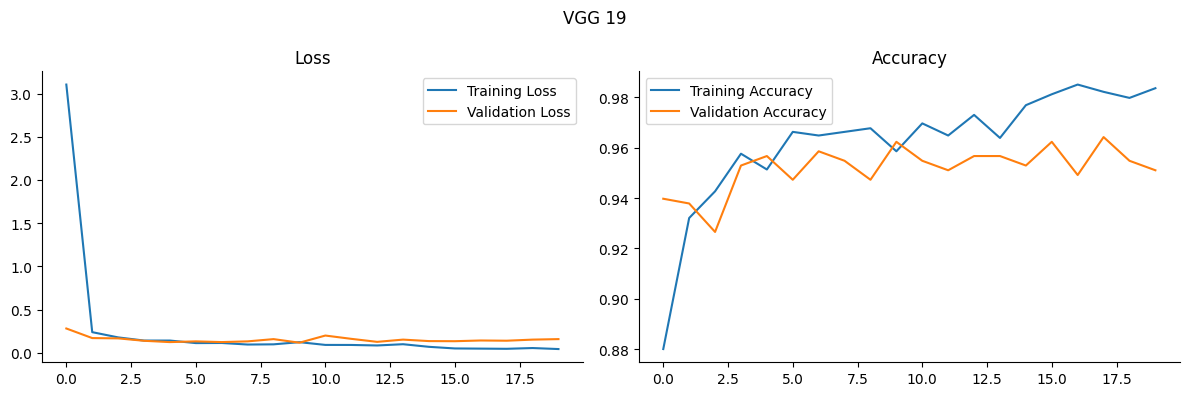

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"],
             ax = axes[0], label = "Training Loss")

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"],
             ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["accuracy"],
             ax = axes[1], label = "Training Accuracy")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["val_accuracy"],
             ax = axes[1], label = "Validation Accuracy")

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
fig.suptitle("VGG 19")

plt.tight_layout()

sns.despine()
plt.savefig('mobile_net_v2.eps', format = 'eps', dpi = 1200)
plt.savefig('mobile_net_v2.png', format = 'png', dpi = 1200)

In [ ]:
!zip -r /content/mobile_net_v2.zip /custom_cnn.tf

  adding: custom_cnn.tf/ (stored 0%)
  adding: custom_cnn.tf/keras_metadata.pb (deflated 96%)
  adding: custom_cnn.tf/assets/ (stored 0%)
  adding: custom_cnn.tf/variables/ (stored 0%)
  adding: custom_cnn.tf/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: custom_cnn.tf/variables/variables.index (deflated 76%)
  adding: custom_cnn.tf/fingerprint.pb (stored 0%)
  adding: custom_cnn.tf/saved_model.pb (deflated 91%)


In [ ]:
m2 = tf.keras.models.load_model('/custom_cnn.tf')

In [ ]:
m2.evaluate(test_set)

8/8 [==============================] - 2s 85ms/step - loss: 0.1228 - accuracy: 0.9740


[0.12280174344778061, 0.9740259647369385]